     Feature           VIF
10        Tt           inf
2        THt           inf
11       TCr           inf
4         CT  9.140627e+06
1        THT  5.806691e+03
6         DT  4.742955e+03
0         NT  7.448627e+01
3      THQCr  3.435367e+01
18        Cr  1.800381e+01
12         C  1.676836e+01
9         TT  1.567891e+01
7         Dt  1.532696e+01
14        Mn  1.150155e+01
17        Ni  9.731566e+00
5         Ct  7.672958e+00
20        Mo  3.683637e+00
8        QmT  3.477983e+00
13        Si  2.579752e+00
22        dA  2.298362e+00
16         S  1.765300e+00
19        Cu  1.721624e+00
23        dB  1.488793e+00
24        dC  1.398450e+00
21  RedRatio  1.377030e+00
15         P  1.307898e+00


<Figure size 1000x600 with 0 Axes>

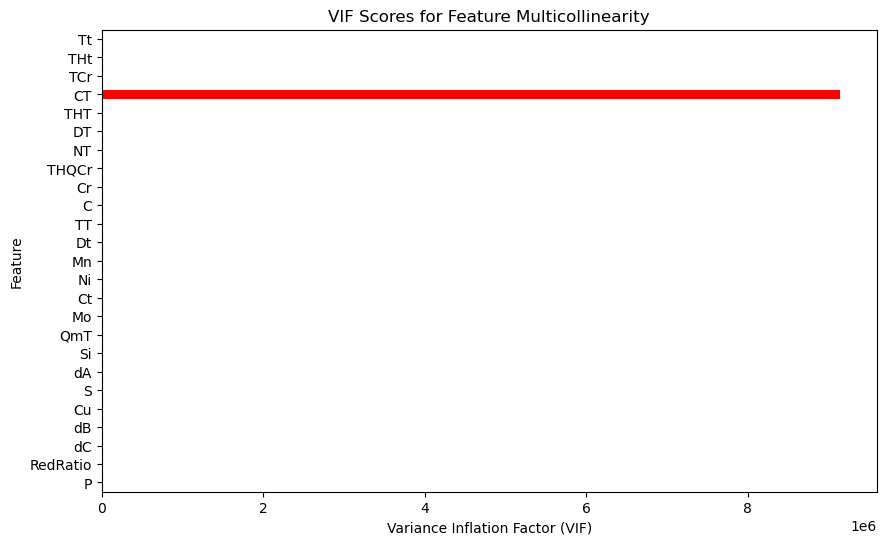

In [12]:
# This code will compute VIF, sort the features, and generate a bar plot for better visualization.

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
data_path = "../data/archive/data.csv"  # Adjust the path if needed
df = pd.read_csv(data_path)

# Drop 'Sl. No.' (if present) and the target variable 'Fatigue'
X = df.drop(columns=['Fatigue', 'Sl. No.'], errors='ignore')  

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Sort VIF scores in descending order
vif_data_sorted = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data_sorted)

# Generate a bar plot for VIF scores
plt.figure(figsize=(10, 6))
vif_data_sorted.plot(kind="barh", x="Feature", y="VIF", legend=False, color="red", figsize=(10, 6))
plt.xlabel("Variance Inflation Factor (VIF)")
plt.ylabel("Feature")
plt.title("VIF Scores for Feature Multicollinearity")
plt.gca().invert_yaxis()  # Invert for better visualization
plt.show()



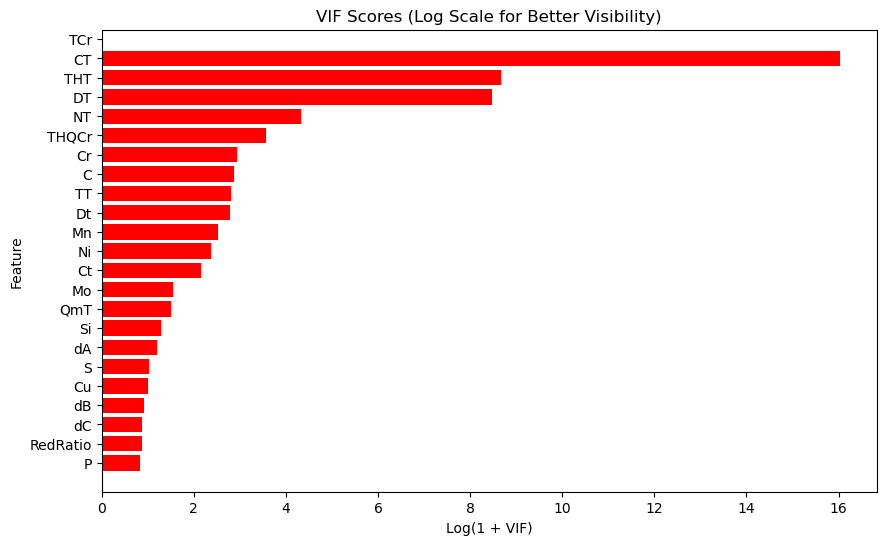

In [13]:
# Fixes the visibility issue
# Compresses extreme values while preserving rankings
import numpy as np

# Apply Log Scale to VIF for better visibility
vif_data_sorted["Log VIF"] = np.log1p(vif_data_sorted["VIF"])

# Plot VIF Scores on Log Scale
plt.figure(figsize=(10, 6))
plt.barh(vif_data_sorted["Feature"], vif_data_sorted["Log VIF"], color="red")
plt.xlabel("Log(1 + VIF)")
plt.ylabel("Feature")
plt.title("VIF Scores (Log Scale for Better Visibility)")
plt.gca().invert_yaxis()
plt.show()

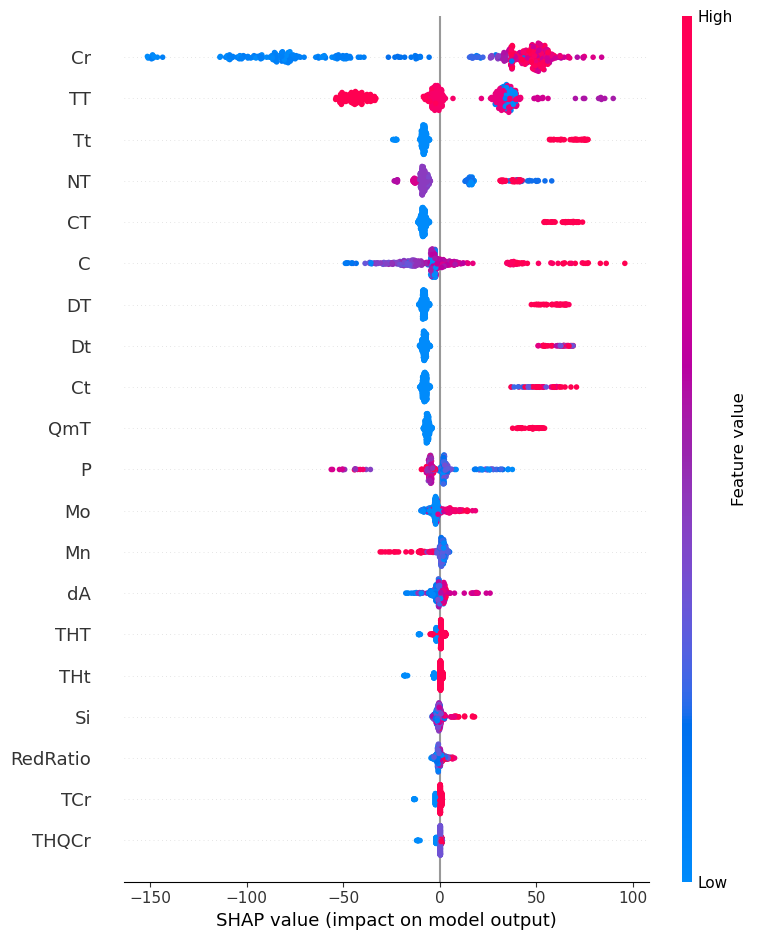

In [5]:
import shap
from sklearn.ensemble import RandomForestRegressor

# Use same X
y = df['Fatigue']

# Train a Random Forest model
model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(X, y)

# Explain the model using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Get feature importance
shap.summary_plot(shap_values, X)


     Feature  SHAP Value
18        Cr   58.080691
9         TT   29.555963
10        Tt   15.180269
0         NT   14.794017
4         CT   14.631577
12         C   14.510500
6         DT   13.748759
7         Dt   13.715521
5         Ct   12.707138
8        QmT   10.900728
15         P    6.947029
20        Mo    3.639407
14        Mn    2.799806
22        dA    2.615284
1        THT    1.620826
2        THt    1.459762
13        Si    1.451227
21  RedRatio    1.380860
11       TCr    1.039437
3      THQCr    0.955618
16         S    0.949064
17        Ni    0.669850
19        Cu    0.669808
23        dB    0.486210
24        dC    0.420863


<Figure size 1000x600 with 0 Axes>

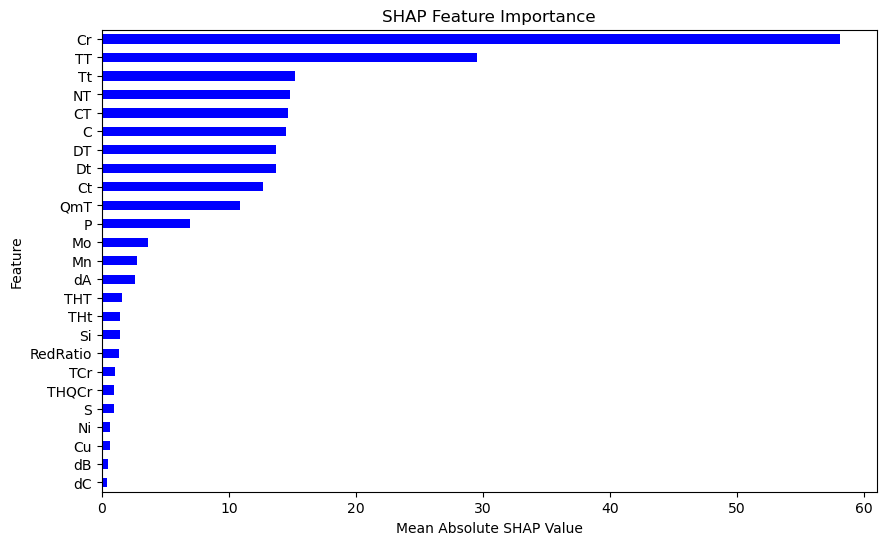

In [9]:

# Create a dataframe for feature importance values
shap_importance = pd.DataFrame({"Feature": X.columns, "SHAP Value": abs(shap_values).mean(axis=0)})
shap_importance = shap_importance.sort_values(by="SHAP Value", ascending=False)

# Print the feature importance values
print(shap_importance)

# Generate SHAP bar plot for clearer ranking
plt.figure(figsize=(10, 6))
shap_importance.plot(kind="barh", x="Feature", y="SHAP Value", legend=False, color="blue", figsize=(10, 6))
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.title("SHAP Feature Importance")
plt.gca().invert_yaxis()  # Invert for better visualization
plt.show()

Now that we have VIF and SHAP feature importance results, let’s finalize feature selection methodically.

🔹 Identify Features to Remove
We will remove features that are redundant based on: 

✅ VIF > 5 → Indicates high multicollinearity (drop the less important ones).

✅ SHAP Value close to 0 → Feature has low impact on predictions.

✅ Both VIF and SHAP agree on removal → Strong candidate for dropping.


📌 Action: List Features to Remove
Let's categorize the features based on VIF and SHAP results.

1️⃣ Features with Extremely High VIF (Multicollinearity Concern)
From our VIF results:

- Tt (∞)
- THt (∞)
- TCr (∞)
- CT (9.14M)
- THT (5806.69)
- DT (4742.95)

🚨 These are highly redundant and should likely be removed.

2️⃣ Features with Very Low SHAP Importance
From SHAP results (values close to 0):

- THQCr (0.96)
- S (0.95)
- Ni (0.67)
- Cu (0.67)
- dB (0.49)
- dC (0.42)

🚨 These features contribute very little to predictions.

In [15]:
# Now, we will drop features that fail both VIF and SHAP criteria and keep the rest.

# List of features to remove based on VIF and SHAP analysis
features_to_remove = [
    "Tt", "THt", "TCr", "CT", "THT", "DT",  # High VIF
    "THQCr", "S", "Ni", "Cu", "dB", "dC"   # Low SHAP importance
]

# Drop these features from the dataset
X_selected = X.drop(columns=features_to_remove, errors='ignore')

# Display the final selected features
print("Final Selected Features:", X_selected.columns.tolist())


Final Selected Features: ['NT', 'Ct', 'Dt', 'QmT', 'TT', 'C', 'Si', 'Mn', 'P', 'Cr', 'Mo', 'RedRatio', 'dA']
